# Convolutional Neural Network (CNN) for Urban Waste Classification

## 1) Imports

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob, os, random
import seaborn as sns
import warnings
import shutil
import tensorflow as tf
import plotly.express as px
import plotly.graph_objects as go
import keras.applications.resnet_v2 as resnet_v2

from plotly.subplots import make_subplots
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, RandomFlip, RandomRotation, RandomZoom, Dropout, Lambda
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image

warnings.simplefilter('ignore')

## 2) Data understanding

### 2.1) Data Collection

In [2]:
path = r'garbage_classification'
all_folds = os.listdir(path)

### 2.2) Exploratory Data Analysis

In [3]:
def data_info(path, all_folds):

    img_list = glob.glob(os.path.join(path, '*/*.jpg'))

    df = pd.DataFrame()
    df['Class'] = [fold for fold in all_folds]
    df['Files'] = [
        len(os.listdir(os.path.join(path, fold))) for fold in all_folds
    ]
    df = df.sort_values(by='Files', ascending=True)

    fig = make_subplots(rows=2,
                        cols=2,
                        column_widths=[0.6, 0.4],
                        row_heights=[0.4, 0.6],
                        specs=[[{
                            "type": "bar",
                            "rowspan": 2
                        }, {
                            "type": "indicator"
                        }], [None, {
                            "type": "indicator"
                        }]])

    fig.add_trace(
        go.Bar(x=df['Files'],
               y=df['Class'],
               orientation='h',
               text=df['Files'],
               textposition='inside'),
        row=1,
        col=1,
    )

    fig.add_trace(go.Indicator(value=len(img_list),
                               title={'text': 'Number of images'}),
                  row=1,
                  col=2)

    fig.add_trace(go.Indicator(value=len(all_folds),
                               title={'text': 'Number of classes'}),
                  row=2,
                  col=2)

    fig.update_layout(margin=dict(r=10, t=25, b=40, l=60),
                      plot_bgcolor='rgba(0,0,0,0)')

    fig.show("png")

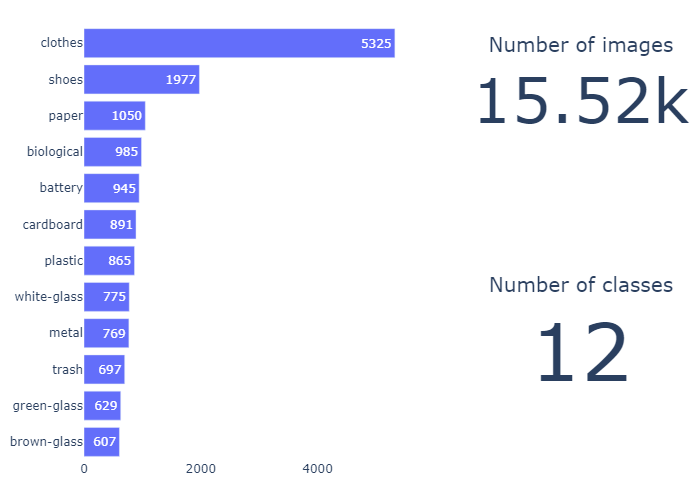

In [4]:
data_info(path, all_folds)

In [5]:
def img_examples(path, all_folds):

    print('Image examples: ')

    i = 0

    plt.figure(figsize=(15, 15))

    for fold in all_folds:

        directory = os.path.join(path, fold)

        img_path = os.path.join(path, fold,
                                random.choice(os.listdir(directory)))
        img = load_img(img_path)

        img = img_to_array(img, dtype=np.uint8)

        plt.subplot(3, 4, i + 1)

        plt.imshow(img.squeeze())

        plt.title(fold)

        plt.axis("off")

        i = i + 1

Image examples: 


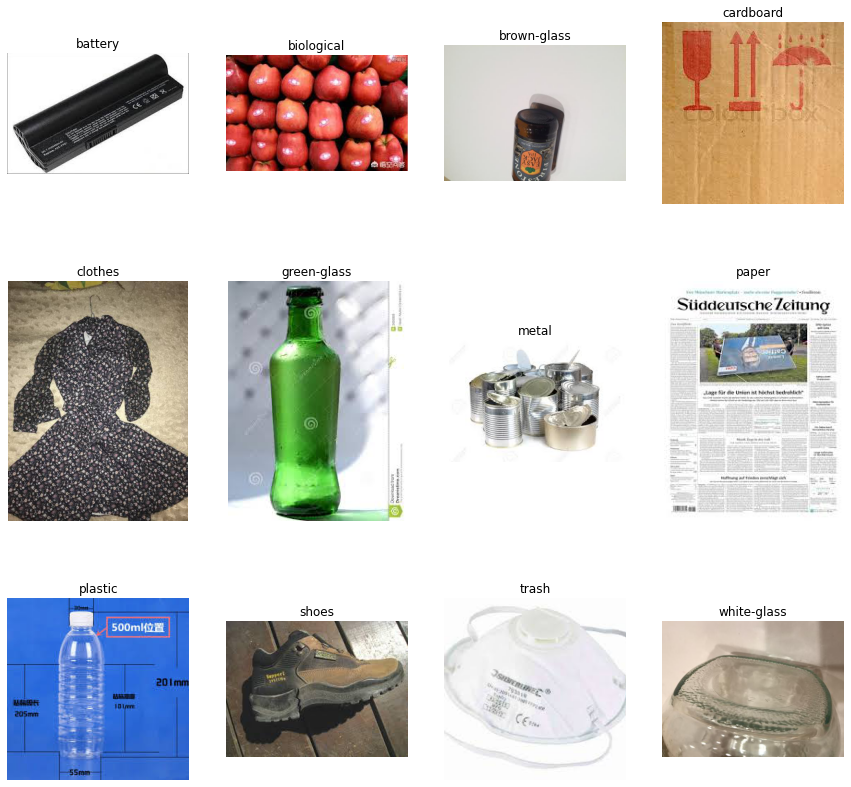

In [6]:
img_examples(path, all_folds)

## 3) Data Wrangling

### 3.1) Merging folds

#### 3.1.1) Cardboard and paper

Since cardboard and paper are made from the same material and have similar shape, we can consider both as just one class. Let's create a single directory for both and move the data to it.

In [7]:
cardboard_and_paper = os.path.join(path, 'cardboard-and-paper')

os.mkdir(cardboard_and_paper)

for fold in ["cardboard", "paper"]:

    directory = os.path.join(path, fold)

    for file in os.listdir(directory):

        source = os.path.join(directory, file)

        shutil.move(source, cardboard_and_paper)

    os.rmdir(directory)

#### 3.1.2) Brown, green and white glass

The same criteria can be used for brown, green and white glass. Both are the same material and have the same shape and purpose with just different colors. We can simply move them all in a single directory called glass.

In [8]:
glass = os.path.join(path, 'glass')

os.mkdir(glass)

for fold in ["brown-glass", "green-glass", "white-glass"]:

    directory = os.path.join(path, fold)

    for file in os.listdir(directory):

        source = os.path.join(directory, file)

        shutil.move(source, glass)

    os.rmdir(directory)

### 3.1) Dropping folds

The directory 'trash' has images from different materials and shapes. In order to have classes with more balanced images, this directory will be removed from the analysis

In [9]:
directory = os.path.join(path, 'trash')
shutil.rmtree(directory)

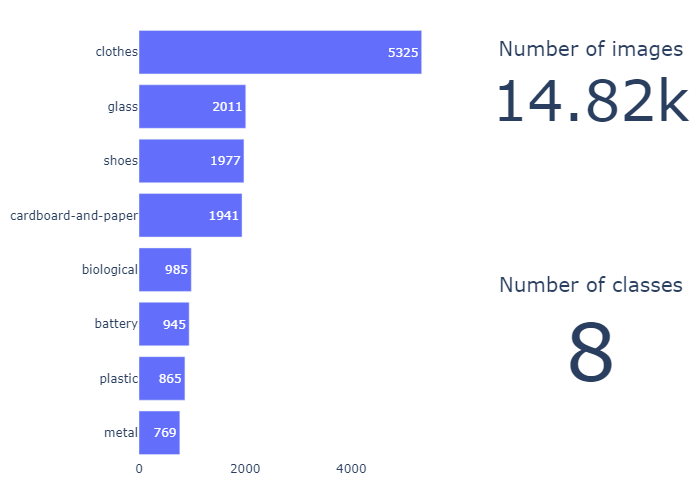

Image examples: 


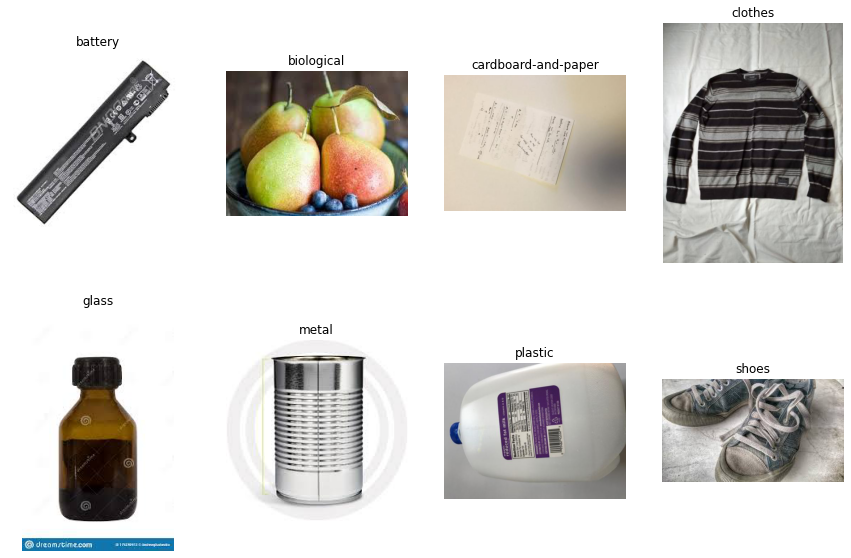

In [10]:
all_folds = os.listdir(path)
data_info(path, all_folds)
img_examples(path, all_folds)

### 3.2) Dealing with imbalanced data

The labels of the dataset are imbalanced. The fold with clothes data have 5325 imagens while the fold with metal has only 769 images. In order to take a more balanced dataset, let's use undersampling technique to take only 769 random images from each fold and pass them to another directory.

First, let's create the new directory that will host the new folders for the balanced data:

In [11]:
new_directory = os.path.join(path, 'balanced_data')

In [12]:
os.mkdir(new_directory)

new_directory

'garbage_classification\\balanced_data'

Now, let's take 769 examples from each fold from the old directory and move them to new folds in the new directory

In [13]:
def move_folds(path, all_folds2):

    for fold in all_folds2:

        directory = os.path.join(path, fold)

        random_files = random.sample(os.listdir(directory), 769)

        new_fold = os.path.join(new_directory, fold)

        os.mkdir(new_fold)

        for file in random_files:

            source = os.path.join(directory, file)

            shutil.copy(source, new_fold)

In [14]:
move_folds(path, all_folds)

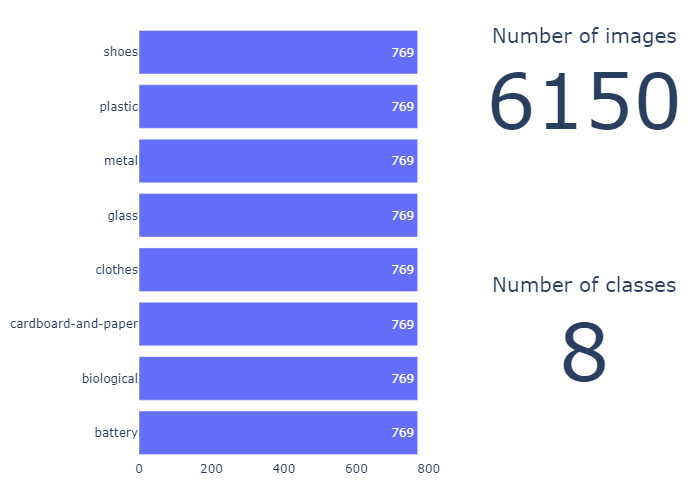

Image examples: 


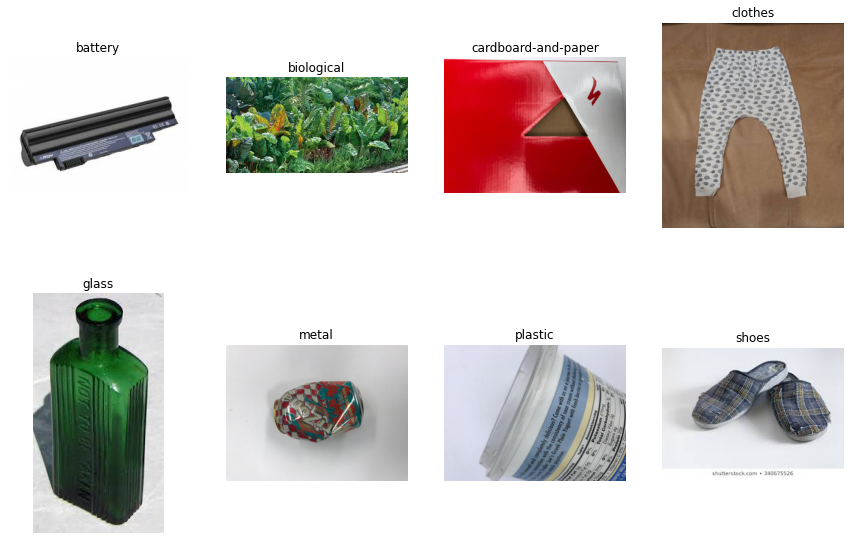

In [15]:
path = new_directory
data_info(path, all_folds)
img_examples(path, all_folds)

### 3.3) Data augmentation

In [16]:
datagen = ImageDataGenerator(rotation_range=10,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             brightness_range=[0.2, 1.2],
                             validation_split=0.2)

(-0.5, 511.5, 383.5, -0.5)

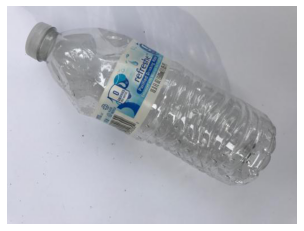

In [17]:
fold_path = os.path.join(path, random.choice(all_folds))
img_path = os.path.join(fold_path, random.choice(os.listdir(fold_path)))
img = load_img(img_path)
plt.imshow(img)
plt.axis('off')

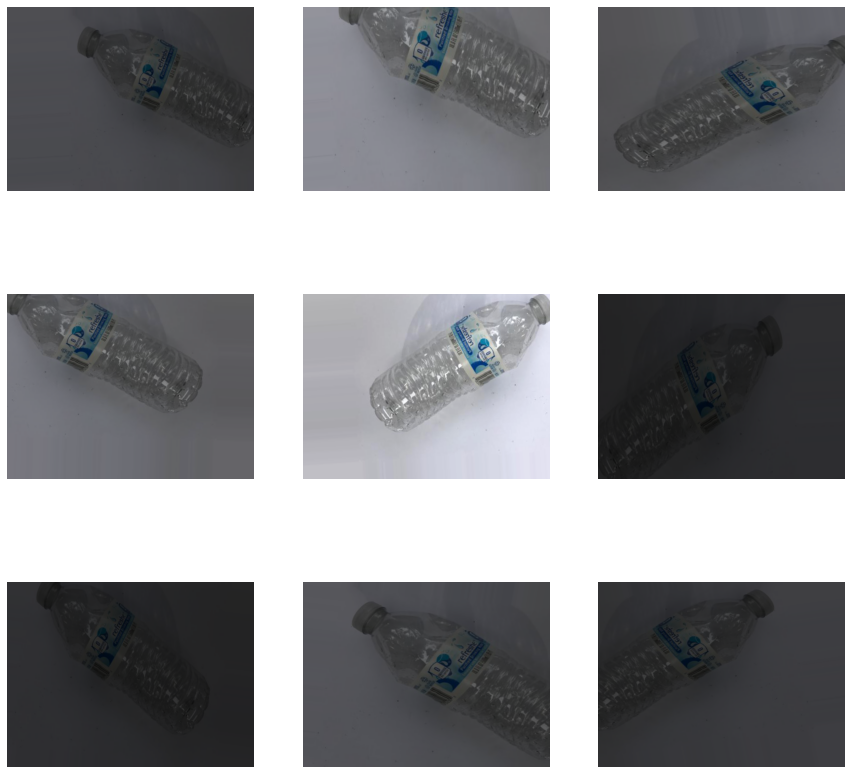

In [18]:
img = img_to_array(img)

samples = np.expand_dims(img, 0)

img_batches = datagen.flow(samples, batch_size=1)

plt.figure(figsize=(15, 15))

for i in range(9):

    plt.subplot(3, 3, i + 1)

    batch = img_batches.next()

    image = batch[0].astype('uint8')

    plt.imshow(image)

    plt.axis('off')

plt.show()

## 4) Modeling

In [19]:
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256
IMAGE_CHANNELS = 3

train = datagen.flow_from_directory(path,
                                    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
                                    batch_size=128,
                                    class_mode='binary',
                                    subset='training')

val = datagen.flow_from_directory(path,
                                  target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
                                  batch_size=128,
                                  class_mode='binary',
                                  subset='validation',
                                  shuffle=False)

Found 4928 images belonging to 8 classes.
Found 1224 images belonging to 8 classes.


In [20]:
baseModel = tf.keras.applications.ResNet50V2(input_shape=(IMAGE_WIDTH,
                                                          IMAGE_HEIGHT,
                                                          IMAGE_CHANNELS),
                                             weights='imagenet',
                                             include_top=False,
                                             classes=train.num_classes)

baseModel.trainable = False

In [23]:
model = Sequential()
model.add(tf.keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))


def ResNet50V2_preprocessing(img):
    return resnet_v2.preprocess_input(img)


model.add(Lambda(ResNet50V2_preprocessing))

model.add(baseModel)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(train.num_classes, activation='softmax'))

model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),
              optimizer=Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 8, 8, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 16392     
Total params: 23,581,192
Trainable params: 16,392
Non-trainable params: 23,564,800
_________________________________________________________________


In [24]:
epochs = 10

history = model.fit_generator(train, validation_data=val, epochs=epochs)

Epoch 1/10
39/39 [==============================] - 659s 17s/step - loss: 0.9590 - accuracy: 0.6918 - val_loss: 0.4524 - val_accuracy: 0.8627
Epoch 2/10
39/39 [==============================] - 685s 18s/step - loss: 0.3640 - accuracy: 0.8833 - val_loss: 0.3539 - val_accuracy: 0.8815
Epoch 3/10
39/39 [==============================] - 679s 17s/step - loss: 0.2831 - accuracy: 0.9148 - val_loss: 0.3327 - val_accuracy: 0.8889
Epoch 4/10
39/39 [==============================] - 629s 16s/step - loss: 0.2573 - accuracy: 0.9213 - val_loss: 0.2990 - val_accuracy: 0.9077
Epoch 5/10
39/39 [==============================] - 646s 17s/step - loss: 0.2202 - accuracy: 0.9324 - val_loss: 0.2765 - val_accuracy: 0.9126
Epoch 6/10
39/39 [==============================] - 665s 17s/step - loss: 0.2032 - accuracy: 0.9347 - val_loss: 0.2932 - val_accuracy: 0.8995
Epoch 7/10
39/39 [==============================] - 630s 16s/step - loss: 0.1817 - accuracy: 0.9448 - val_loss: 0.2750 - val_accuracy: 0.9109
Epoch 

In [25]:
model.save('Users\henrique.maciel\garbage_classification')

INFO:tensorflow:Assets written to: Users\henrique.maciel\garbage_classification\assets


## 5) Evaluation

In [26]:
model = load_model('Users\henrique.maciel\garbage_classification')

In [27]:
model.evaluate(val)

10/10 [==============================] - 144s 14s/step - loss: 0.2755 - accuracy: 0.9036


[0.27550241351127625, 0.9035947918891907]

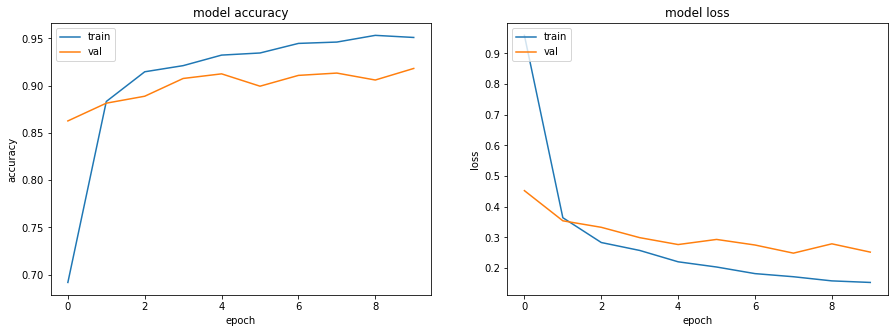

In [28]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [41]:
Y_pred = model.predict_generator(val)
y_pred = np.argmax(Y_pred, axis=1)

<AxesSubplot:>

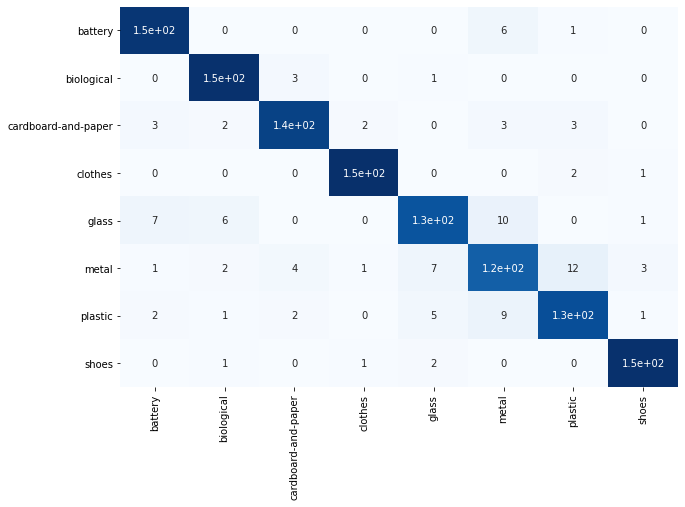

In [51]:
df_cm = pd.DataFrame(confusion_matrix(val.classes, y_pred), index = [i for i in val.class_indices.keys()],
                  columns = [i for i in val.class_indices.keys()])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap="Blues", cbar=False)

In [40]:
print('Classification Report')
print(classification_report(val.classes, y_pred, target_names=val.class_indices.keys()))

Classification Report
                     precision    recall  f1-score   support

            battery       0.94      0.96      0.95       153
         biological       0.94      0.96      0.95       153
cardboard-and-paper       0.93      0.90      0.91       153
            clothes       0.98      0.99      0.99       153
              glass       0.91      0.82      0.86       153
              metal       0.80      0.86      0.83       153
            plastic       0.86      0.84      0.85       153
              shoes       0.97      0.99      0.98       153

           accuracy                           0.92      1224
          macro avg       0.92      0.92      0.91      1224
       weighted avg       0.92      0.92      0.91      1224

